In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [2]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 15.5 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
# Load spacy English languague model
NER = spacy.load("en_core_web_sm")

## Load books

In [4]:
import os
 
# Get all book files in the data directory
all_books = [b for b in os.scandir('data') if '.txt' in b.name]

In [5]:
all_books

[<DirEntry '2 The Sword of Destiny.txt'>,
 <DirEntry '3 Blood of Elves.txt'>,
 <DirEntry '7 The Lady of the Lake.txt'>,
 <DirEntry '4 Times of Contempt.txt'>,
 <DirEntry '1 The Last Wish.txt'>,
 <DirEntry '8 something ends something begins.txt'>,
 <DirEntry '6 The Tower of the Swallow.txt'>,
 <DirEntry '5 Baptism of Fire.txt'>]

In [6]:
book = all_books[1]
book_text = open(book).read()
book_doc = NER(book_text)

In [7]:
# Visualize identified entities
displacy.render(book_doc[0:2000], style="ent", jupyter=True)

## Load character names

In [8]:
# Read characters
character_df = pd.read_csv("characters.csv")

In [11]:
# Remove brackets and text within brackets
import re
character_df['character'] = character_df['character'].apply(lambda x: re.sub(r"\(.*?\)", "", x))
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])

In [ ]:
pd.set_option('display.max_rows', None)
character_df

## Get named entity list per sentence

In [13]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [ ]:
sent_entity_df

In [15]:
# Function to filter out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character) 
            or ent in list(character_df.character_firstname)]

In [16]:
filter_entity(["Geralt", "Thu", "2"], character_df)

['Geralt']

In [17]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
9,"(Aen, Ithlinnespeath, ,, Ithlinne, Aegli, aep,...","[Aen Ithlinnespeath, Ithlinne Aegli, Aevenien]",[Aevenien]
73,"(And, she, is, frozen, in, fear, :, a, terribl...",[Ciri],[Ciri]
138,"(And, she, is, frozen, in, fear, :, a, terribl...",[Ciri],[Ciri]
165,"(Ciri, shuddered, violently, ,, curling, her, ...",[Ciri],[Ciri]
169,"(', Geralt, ,, I-, ', \n, ', I, 'm, right, her...",[Geralt],[Geralt]
185,"(Hold, ..., \n, ', Geralt, ?, ', \n, ', What, ...",[Geralt],[Geralt]
200,"(Ciri, had, been, frightened, of, them, ,, she...",[Ciri],[Ciri]
207,"(Ciri, had, heard, such, reassurances, in, the...",[Ciri],[Ciri]
211,"(Because, it, was, Geralt, of, Rivia, ,, the, ...","[Geralt, the White Wolf]",[Geralt]
224,"(', Allow, me, ,, Radcliffe, of, \n, Oxenfurt,...","[Radcliffe, Arcana]",[Radcliffe]


In [18]:
# Take only first name of characters
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

/var/folders/7_/k7nwd1nx3_746wyfkvsd75k40000gn/T/ipykernel_17060/364234938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


In [19]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

,sentence,entities,character_entities
9,"(Aen, Ithlinnespeath, ,, Ithlinne, Aegli, aep,...","[Aen Ithlinnespeath, Ithlinne Aegli, Aevenien]",[Aevenien]
73,"(And, she, is, frozen, in, fear, :, a, terribl...",[Ciri],[Ciri]
138,"(And, she, is, frozen, in, fear, :, a, terribl...",[Ciri],[Ciri]
165,"(Ciri, shuddered, violently, ,, curling, her, ...",[Ciri],[Ciri]
169,"(', Geralt, ,, I-, ', \n, ', I, 'm, right, her...",[Geralt],[Geralt]
...,...,...,...
10322,"(Nenneke, did, not, look, at, \n, them, ., \n)",[Nenneke],[Nenneke]
10325,"(It, might, turn, out, to, be, true, ,, what, ...","[Ithlinne, Aevenien]","[Ithlinne, Aevenien]"
10328,"(Take, care, of, her, ,, Yennefer, .)",[Yennefer],[Yennefer]
10330,"(', I, 'll, be, back, ,, Mother, ,, ', said, C...",[Ciri],[Ciri]


## Create relationships

In [20]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [21]:
relationship_df = pd.DataFrame(relationships)

In [ ]:
pd.set_option('display.max_rows', None)
relationship_df

In [ ]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df

In [25]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [ ]:
relationship_df

## Graph analysis and visualization

In [28]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

#### Graph visualization - Networkx

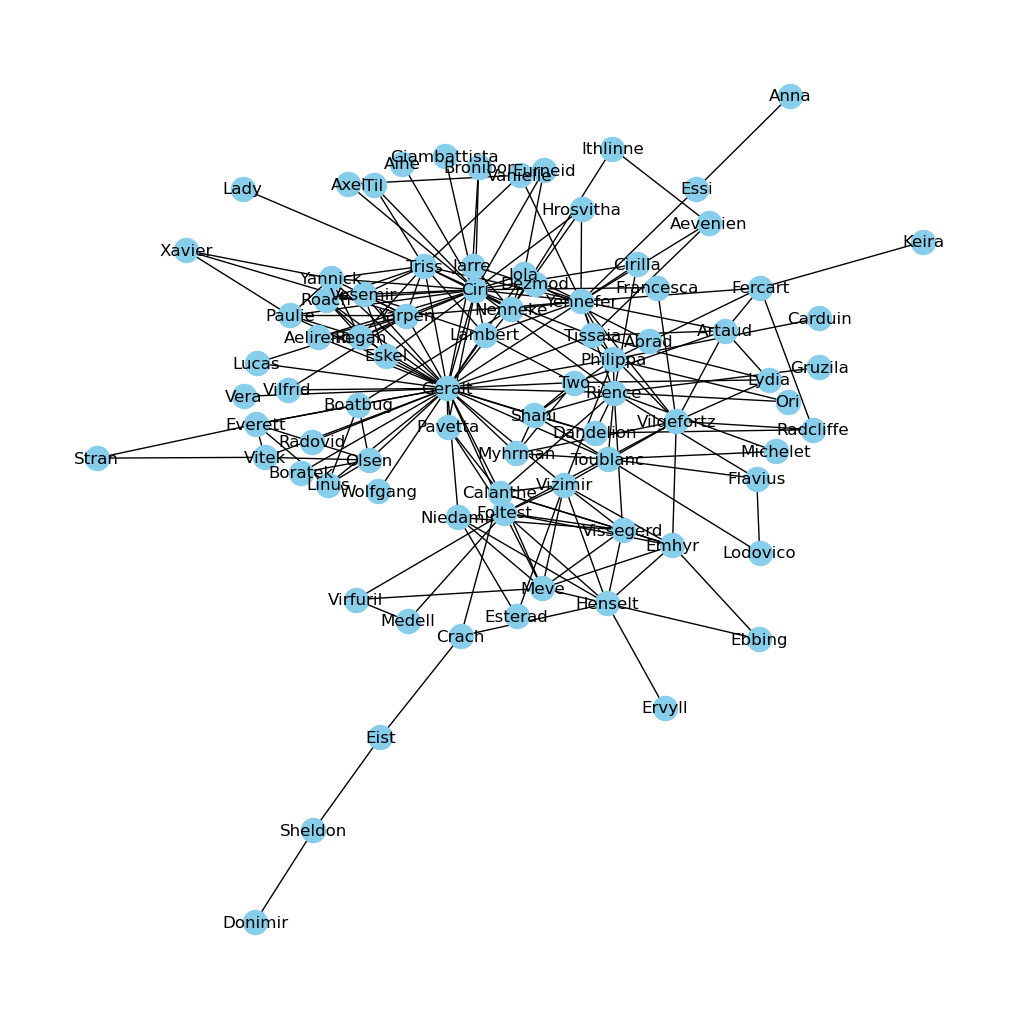

In [29]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

#### Graph visualization - Pyvis

In [31]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white', cdn_resources='in_line')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("witcher.html")

witcher.html


### The most important characters in The Witcher

In [32]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Ciri': 0.3373493975903615,
 'Geralt': 0.46987951807228917,
 'Yennefer': 0.22891566265060243,
 'Cirilla': 0.03614457831325302,
 'Donimir': 0.012048192771084338,
 'Sheldon': 0.024096385542168676,
 'Vera': 0.012048192771084338,
 'Pavetta': 0.04819277108433735,
 'Calanthe': 0.10843373493975904,
 'Eist': 0.024096385542168676,
 'Dandelion': 0.04819277108433735,
 'Radcliffe': 0.03614457831325302,
 'Abrad': 0.012048192771084338,
 'Dezmod': 0.012048192771084338,
 'Rience': 0.16867469879518074,
 'Gruzila': 0.012048192771084338,
 'Niedamir': 0.060240963855421686,
 'Roach': 0.060240963855421686,
 'Eskel': 0.04819277108433735,
 'Lambert': 0.07228915662650603,
 'Vesemir': 0.07228915662650603,
 'Triss': 0.1566265060240964,
 'Til': 0.024096385542168676,
 'Two': 0.07228915662650603,
 'Nenneke': 0.10843373493975904,
 'Vanielle': 0.03614457831325302,
 'Axel': 0.024096385542168676,
 'Fercart': 0.060240963855421686,
 'Keira': 0.012048192771084338,
 'Artaud': 0.07228915662650603,
 'Vilgefortz': 0.12048192

<Axes: >

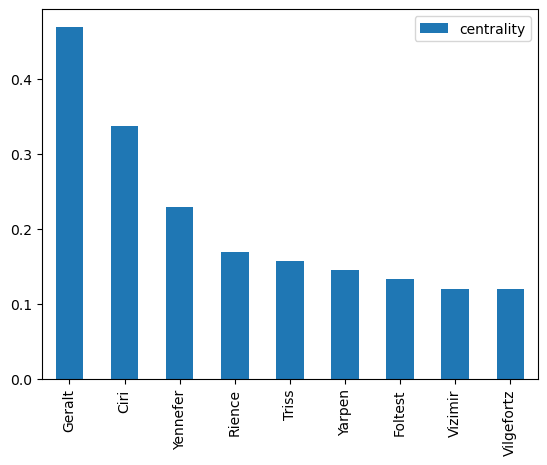

In [33]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

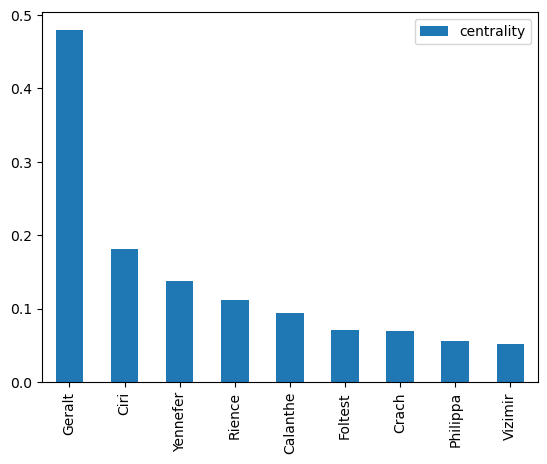

In [34]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

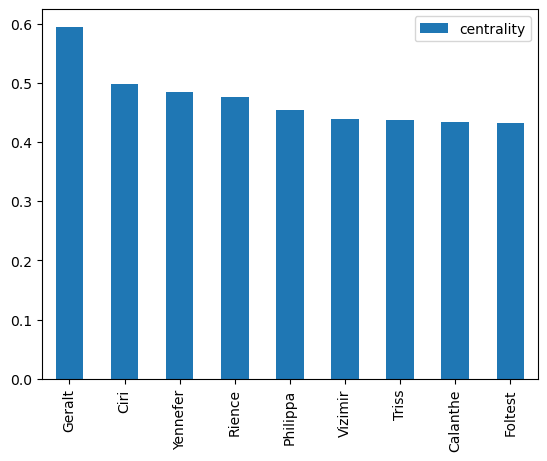

In [35]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [36]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

### Community detection

In [47]:
import community.community_louvain as community_louvain

In [48]:
communities = community_louvain.best_partition(G)

In [49]:
communities

{'Ciri': 3,
 'Geralt': 1,
 'Yennefer': 0,
 'Cirilla': 2,
 'Donimir': 5,
 'Sheldon': 5,
 'Vera': 1,
 'Pavetta': 5,
 'Calanthe': 5,
 'Eist': 5,
 'Dandelion': 2,
 'Radcliffe': 2,
 'Abrad': 4,
 'Dezmod': 4,
 'Rience': 2,
 'Gruzila': 2,
 'Niedamir': 5,
 'Roach': 3,
 'Eskel': 3,
 'Lambert': 3,
 'Vesemir': 3,
 'Triss': 3,
 'Til': 3,
 'Two': 2,
 'Nenneke': 0,
 'Vanielle': 3,
 'Axel': 3,
 'Fercart': 2,
 'Keira': 2,
 'Artaud': 0,
 'Vilgefortz': 0,
 'Yarpen': 3,
 'Xavier': 3,
 'Yannick': 3,
 'Paulie': 3,
 'Regan': 3,
 'Lucas': 3,
 'Vilfrid': 3,
 'Aelirenn': 3,
 'Lady': 3,
 'Radovid': 1,
 'Everett': 1,
 'Iola': 0,
 'Boatbug': 1,
 'Linus': 1,
 'Foltest': 5,
 'Boratek': 1,
 'Olsen': 1,
 'Stran': 1,
 'Vitek': 1,
 'Ori': 2,
 'Philippa': 2,
 'Wolfgang': 1,
 'Shani': 2,
 'Vizimir': 5,
 'Henselt': 5,
 'Ebbing': 5,
 'Emhyr': 5,
 'Ervyll': 5,
 'Meve': 5,
 'Crach': 5,
 'Esterad': 5,
 'Vissegerd': 5,
 'Virfuril': 5,
 'Medell': 5,
 'Myhrman': 2,
 'Toublanc': 2,
 'Flavius': 2,
 'Lodovico': 2,
 'Michelet': 2,
 

In [50]:
nx.set_node_attributes(G, communities, 'group')

In [52]:
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white', cdn_resources='remote')
com_net.from_nx(G)
com_net.show("witcher_communities.html")

witcher_communities.html


### Evolution of characters' importance

In [54]:
from lib.utils.functions import *

In [55]:
# Initialize empty list for graphs from books
books_graph = []
all_books = [b for b in os.scandir('data') if '.txt' in b.name]
# Load spacy English languague model
nlp = spacy.load("en_core_web_sm")

# Sort dir entries by name
all_books.sort(key=lambda x: x.name)

In [56]:
# Loop through book list and create graphs
for book in all_books:
    book_text = ner(book)
    
    # Get list of entities per sentences
    sent_entity_df = get_ne_list_per_sentence(book_text)
    
    # Select only character entities
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

    # Filter out sentences that don't have any character entities
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
    
    # Take only first name of characters
    sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

    # Create relationship df
    relationship_df = create_relationships(df = sent_entity_df_filtered, window_size = 5)                                                                                                               
    
    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(relationship_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())     
    
    books_graph.append(G) 

/var/folders/7_/k7nwd1nx3_746wyfkvsd75k40000gn/T/ipykernel_17060/4223697425.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
/var/folders/7_/k7nwd1nx3_746wyfkvsd75k40000gn/T/ipykernel_17060/4223697425.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


<Axes: >

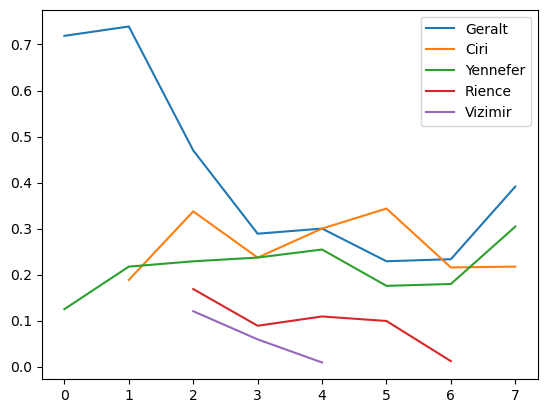

In [57]:
# Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in books_graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting the degree centrality evolution of 5 main characters
degree_evol_df[["Geralt", "Ciri", "Yennefer", "Rience", "Vizimir"]].plot()